In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src')
sys.path.insert(1, '/home/jw3514/Work/UNIMED/src')
from CellType_PSY import *
from UNIMED import *
import yaml
#import scanpy as sc
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol = LoadGeneINFO()

os.chdir("/home/jw3514/Work/UNIMED/notebooks/")

with open("../config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [2]:
bias_path = config["bias_matrices"]["MouseCT"]
BiasMat = pd.read_parquet(bias_path)
BiasMat.head()

0001 CLA-EPd-CTX Car3 Glut_1  0002 CLA-EPd-CTX Car3 Glut_1  \
114786                      0.637386                      0.791460   
6101                        0.000000                      0.000000   
64321                       0.000000                      0.000000   
29088                       0.931420                      0.893492   
10434                       1.046448                      1.135001   

        0003 CLA-EPd-CTX Car3 Glut_1  0004 CLA-EPd-CTX Car3 Glut_1  \
114786                      0.600601                      0.540679   
6101                        0.000000                      0.000000   
64321                       0.000000                      0.000000   
29088                       0.869544                      1.128183   
10434                       1.085187                      1.024766   

        0005 CLA-EPd-CTX Car3 Glut_2  0006 IT EP-CLA Glut_1  \
114786                      0.691849               1.256391   
6101                        0.000000               0.000000   
64321                       0.000000               0.000000   
29088                       1.012409               0.822261   
10434                       0.879166               0.965779   

        0007 IT EP-CLA Glut_1  0008 IT EP-CLA Glut_1  0009 IT EP-CLA Glut_1  \
114786               1.278532               0.828191               1.008509   
6101                 0.000000               0.000000               0.000000   
64321                0.000000               0.000000               0.000000   
29088                0.825340               0.877705               0.896106   
10434                0.887547               0.796679               0.872618   

        0010 IT EP-CLA Glut_1  ...  5313 BAM NN_1  5314 BAM NN_1  \
114786               0.866787  ...       0.001086       0.001300   
6101                 0.000000  ...       0.000000       0.000000   
64321                0.000000  ...       1.161456       1.166957   
29088                0.817871  ...       0.975026       0.982890   
10434                0.957697  ...       1.086723       1.042042   

        5315 Monocytes NN_1  5316 DC NN_1  5317 DC NN_1  5318 DC NN_1  \
114786             0.241094      0.008447      0.003805      0.001619   
6101               0.000000      1.193920      0.000000      0.000000   
64321              0.000000      0.000000      1.190123      0.000000   
29088              1.069866      1.193920      1.119723      1.072728   
10434              0.995750      1.147672      1.006259      1.168291   

        5319 B cells NN_1  5320 ILC NN_2  5321 NK cells NN_3  \
114786           0.003307       0.080730            0.000768   
6101             0.000000       0.000000            1.137792   
64321            0.000000       1.183047            1.137792   
29088            1.164674       1.183047            1.107511   
10434            1.164674       1.117876            1.121739   

        5322 T cells NN_4  
114786           0.000823  
6101             0.000000  
64321            1.178568  
29088            0.945228  
10434            1.137530  

[5 rows x 5312 columns]

In [3]:
PGC_Magma_Correlation = pd.read_csv("/home/jw3514/Work/UNIMED/results/pfactor/PGC_Magma_Correlation.csv", index_col=0)

# Mouse CT

In [4]:
# Read Magma GWAS Results
gwas = "PGC"
Exclude = "Empty"
Mode = "MouseCT"
Bias = "top_gene_enrich"

PGC_Trait_Names = ["ASD", "SCZ", "BP", "ADHD", "MDD", "OCD", "TS", "PD", "AN", "EDU", "PTSD"]

DIR = f"/home/jw3514/Work/UNIMED/results/assoc/{gwas}/{Mode}/{Bias}.{Exclude}"
Psy_GWAS_CTBias_DF = {}
for Name in PGC_Trait_Names:
    Psy_GWAS_CTBias_DF[Name] = pd.read_csv("{}/MouseCT.{}.csv".format(DIR,Name), sep=",", index_col=0)

Psy_GWAS_CTBias_DF["SCZ"].head()

beta        pvalue   class_id_label  \
ct_idx                                                               
0988 STR D2 Gaba_6         0.404683  5.546074e-20  09 CNU-LGE GABA   
0980 STR D2 Gaba_4         0.379634  8.658129e-18  09 CNU-LGE GABA   
0293 CA1-ProS Glut_6       0.377677  1.107014e-17    01 IT-ET Glut   
0324 L2 IT PPP-APr Glut_2  0.375040  2.232659e-17    01 IT-ET Glut   
0987 STR D2 Gaba_6         0.374676  2.137164e-17  09 CNU-LGE GABA   

                                subclass_id_label  
ct_idx                                             
0988 STR D2 Gaba_6                062 STR D2 Gaba  
0980 STR D2 Gaba_4                062 STR D2 Gaba  
0293 CA1-ProS Glut_6            016 CA1-ProS Glut  
0324 L2 IT PPP-APr Glut_2  018 L2 IT PPP-APr Glut  
0987 STR D2 Gaba_6                062 STR D2 Gaba

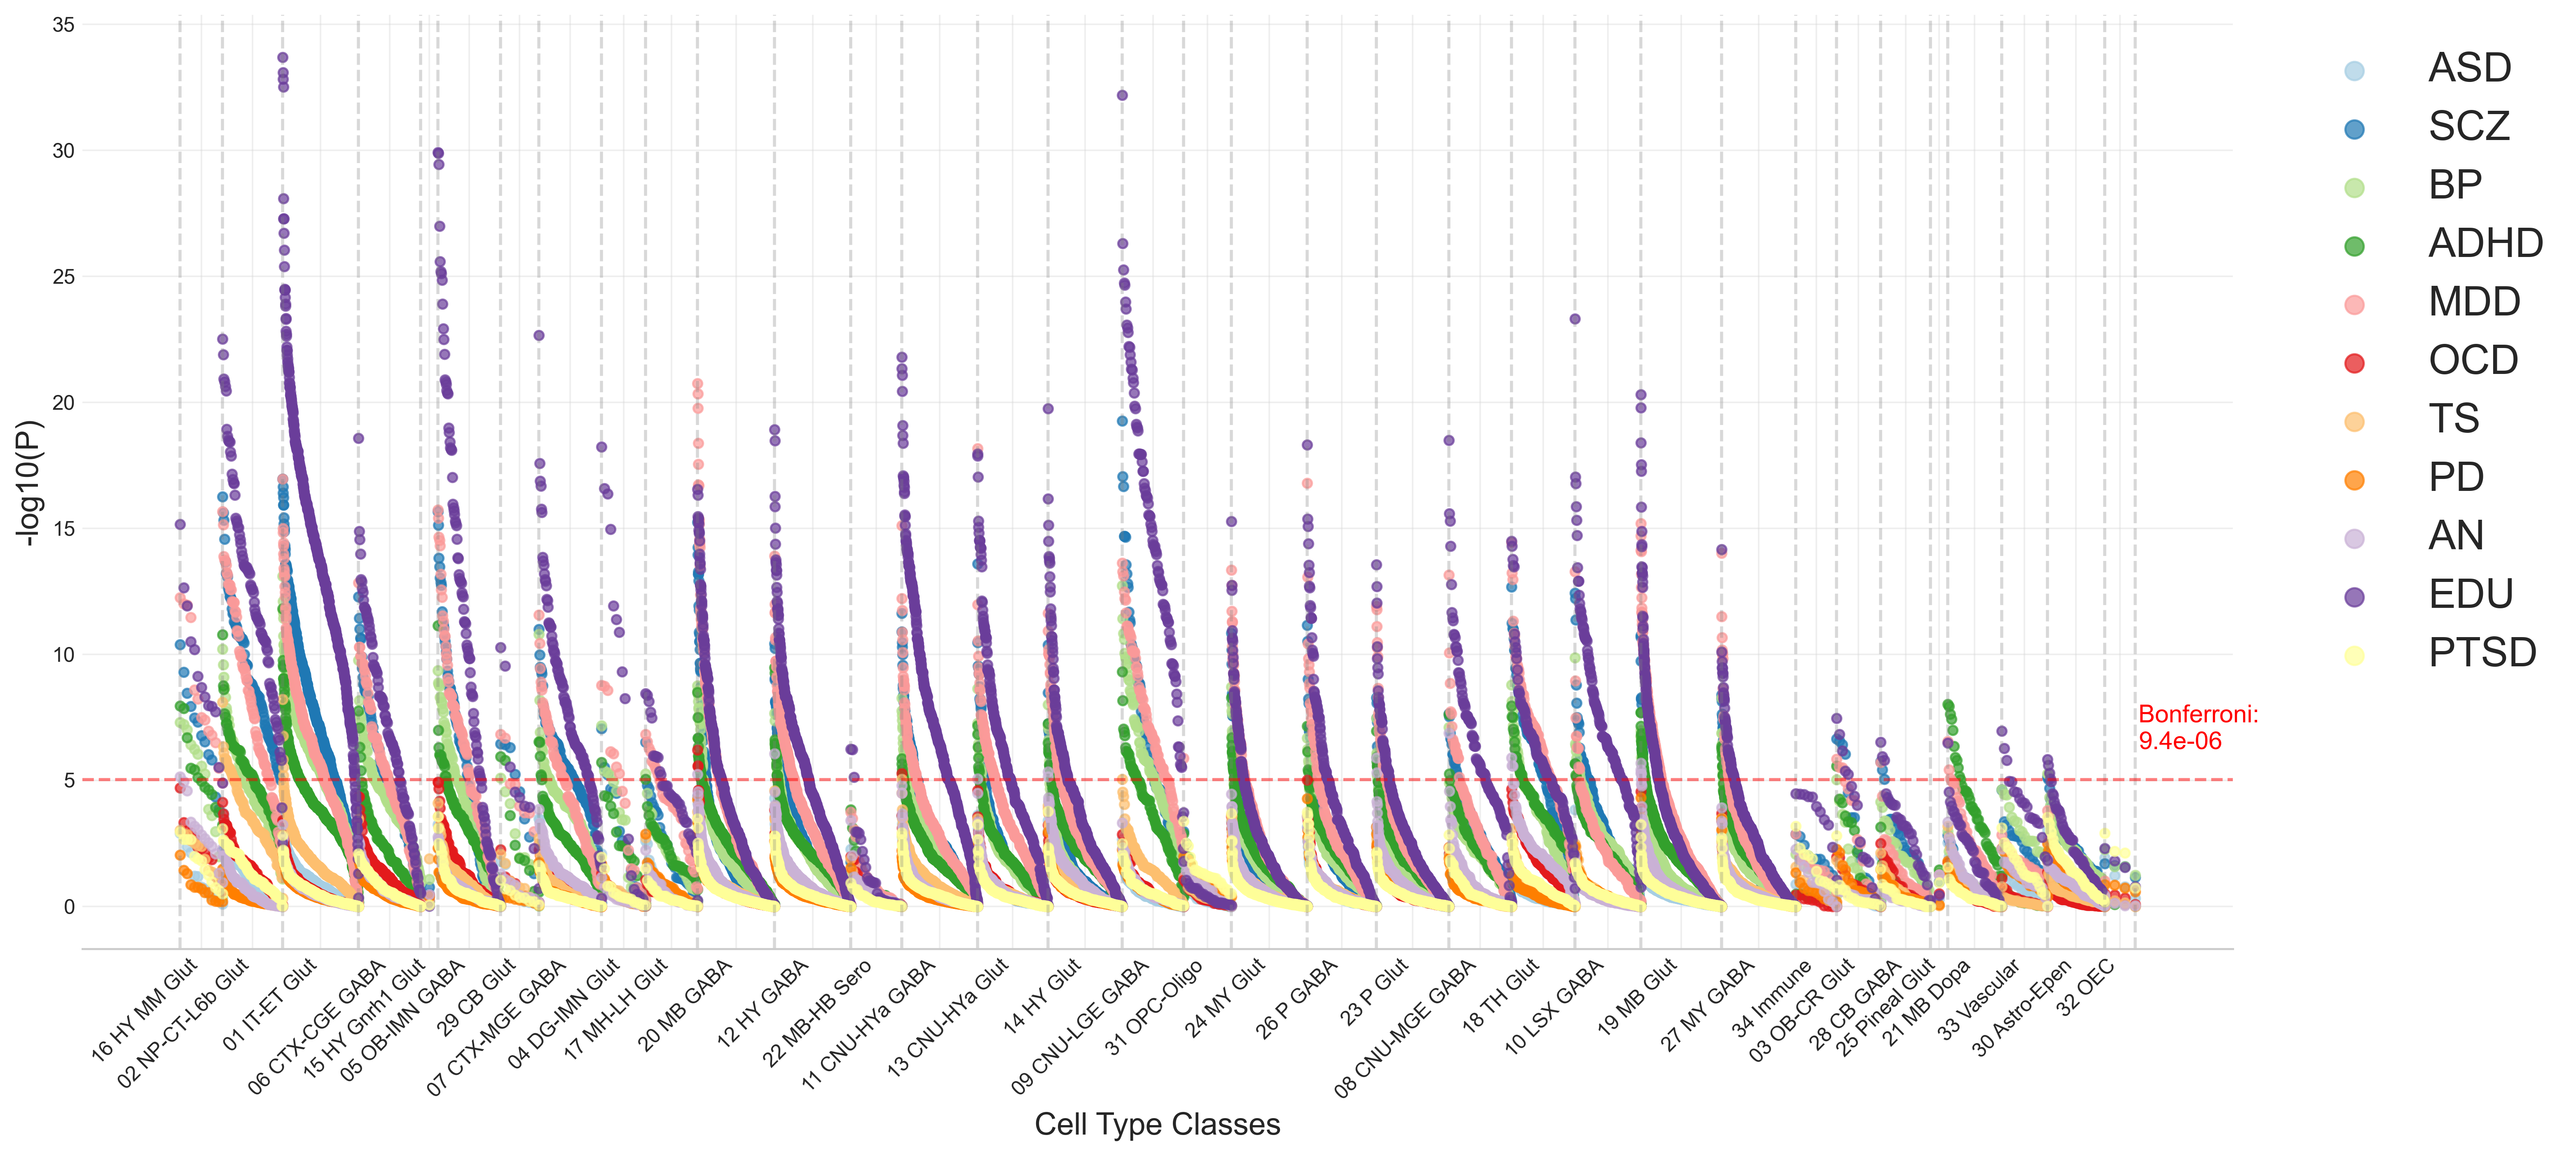

In [5]:
def plot_class_label_specificity(
    Psy_GWAS_CTBias_DF, 
    Disorders, 
    colors, 
    n_tests=5000, 
    figsize=(20, 10), 
    dpi=360
):
    # Create figure with transparent background
    plt.figure(figsize=figsize, dpi=dpi, facecolor='none', edgecolor='none')
    ax = plt.gca()
    ax.set_facecolor('none')

    # Process first disorder to establish common class_id_label ordering
    df_first = Psy_GWAS_CTBias_DF[Disorders[0]].copy()
    class_means = df_first.groupby('class_id_label')['beta'].mean().sort_values(ascending=False)
    sorted_classes = class_means.index.tolist()

    # Calculate class sizes for scaling
    class_sizes = []
    for cl in sorted_classes:
        class_size = len(df_first[df_first['class_id_label'] == cl])
        class_sizes.append(class_size)
    
    # Create log2-based spacing for classes
    # Minimum width per class and scale factor for larger classes
    min_width = 50  # Minimum space for small classes
    scale_factor = 20  # How much additional space larger classes get
    
    class_widths = []
    for size in class_sizes:
        # Use log2 scaling with minimum width
        width = min_width + scale_factor * np.log2(max(1, size))
        class_widths.append(width)
    
    # Calculate class boundaries based on scaled widths
    class_boundaries = [0]
    for width in class_widths:
        class_boundaries.append(class_boundaries[-1] + width)

    # Process each disorder using the same class_id_label ordering
    for disorder, color in zip(Disorders, colors):
        df = Psy_GWAS_CTBias_DF[disorder].copy()
        
        # Convert values to -log10(1-p)
        df['value'] = -np.log10(df['pvalue'])
        
        # Sort data using common class_id_label ordering
        df['class_order'] = df['class_id_label'].map({cl: i for i, cl in enumerate(sorted_classes)})
        df = df.sort_values(['class_order', 'value'], ascending=[True, False])
        
        # Get class grouping info and create scaled x-positions
        x_positions = []
        for _, row in df.iterrows():
            class_idx = row['class_order']
            class_start = class_boundaries[class_idx]
            class_width = class_widths[class_idx]
            
            # Get position within class (0 to 1)
            class_df = df[df['class_order'] == class_idx]
            within_class_idx = list(class_df.index).index(row.name)
            within_class_position = within_class_idx / max(1, len(class_df) - 1) if len(class_df) > 1 else 0.5
            
            # Calculate actual x position
            x_pos = class_start + within_class_position * class_width
            x_positions.append(x_pos)
        
        # Plot points for this disorder
        plt.scatter(x_positions, df['value'], alpha=0.7, color=color, label=disorder, s=20)

    # Add vertical lines at class boundaries
    for boundary in class_boundaries:
        plt.axvline(x=boundary, color='gray', linestyle='--', alpha=0.3)

    # Add horizontal line at Bonferroni threshold
    bonferroni_threshold = -np.log10(0.05/n_tests)
    plt.axhline(y=bonferroni_threshold, color='red', linestyle='--', alpha=0.5)
    # annotate its pvalue
    plt.text(class_boundaries[-1]+10, bonferroni_threshold + 2, f'Bonferroni: \n{0.05/n_tests:.1e}', ha='left', va='center', fontsize=12, color='red')

    # Calculate center position for each class and set up tick positions
    tick_positions = []
    tick_labels = []
    
    for i, cl in enumerate(sorted_classes):
        center_x = (class_boundaries[i] + class_boundaries[i+1]) / 2
        tick_positions.append(center_x)
        tick_labels.append(cl)

    # Set custom x-ticks
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=10)

    # Customize plot
    plt.xlabel('Cell Type Classes', fontsize=15)
    plt.ylabel('-log10(P)', fontsize=15)
    plt.grid(True, alpha=0.3)

    # Move legend outside of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=20, markerscale=2)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Adjust layout to prevent label cutoff and accommodate legend
    plt.subplots_adjust(bottom=0.25, right=0.85)
    plt.show()

# Example usage:
# plot_class_label_specificity(Psy_GWAS_CTBias_DF, PGC_Trait_Names, colors)
colors = [
    "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99",
    "#e31a1c", "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99"
]
plot_class_label_specificity(Psy_GWAS_CTBias_DF, PGC_Trait_Names, colors, n_tests=BiasMat.shape[1])

In [6]:
PsyDisorders_2 = ["ASD", "SCZ", "BP", "ADHD", "MDD", "OCD","TS", "AN", "PTSD", "PD", "EDU"]
#h2_LDSC = [0.118, 0.244, 0.196, 0.199, 0.103, 0.367, 0.252, 0.044, 0.09, ]
h2_LDSC = [0.118, 0.244, 0.196, 0.199, 0.103, 0.28, 0.252, 0.044, 0.09, 0.148, 0.03]
h2_se_LDSC = [0.012, 0.0095, 0.0111, 0.0128, 0.0072, 0.0589, 0.0332, 0.0034, 0.0083, 0.002, 0.003]
SampleSize = [18381, 76755, 41917, 38691 , 88316, 2688, 4819, 74973, 11920, 10000, 2248]
neff_values = [
    21945,   # ASD
    55115,   # SCZ
    71385,   # BP
    26126,   # ADHD
    1014821,   # MDD
    38193,    # OCD
    6371,    # TS
    36647,   # Anxiety
    17531,   # PTSD
    3265,    # PD (Panic Disorder)
    405072   # EDU
]

In [7]:
N_sigCT_list = []
N_sig_count_list = []
for disorder in PsyDisorders_2:
    # Get number of significant cell types (p < 0.05/200)
    N_sig_count = len(Psy_GWAS_CTBias_DF[disorder][Psy_GWAS_CTBias_DF[disorder]["pvalue"] < 0.05/200])
    N_sig_count_list.append(N_sig_count)
    
    # Get mean effect size of top 50 cell types
    N_sigCT = Psy_GWAS_CTBias_DF[disorder].head(50)["beta"].mean()
    N_sigCT_list.append(N_sigCT)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


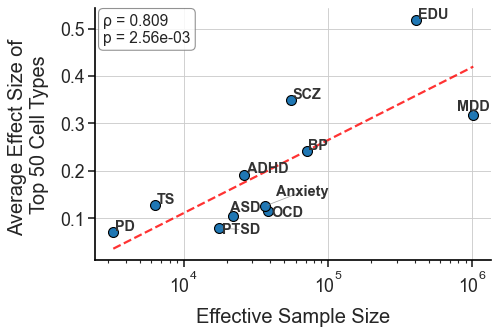

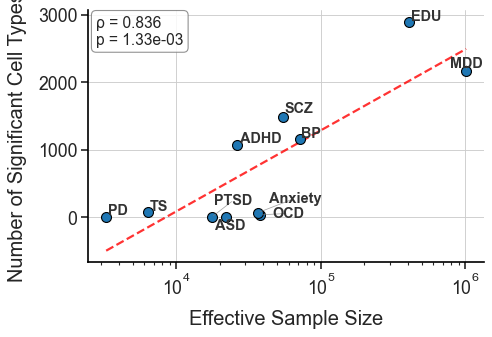

In [8]:
create_scatter_plot(
    x_values=neff_values,
    y_values=N_sigCT_list,
    xlabel="Effective Sample Size",
    ylabel="Average Effect Size of \nTop 50 Cell Types", 
    disorders=['ASD', 'SCZ', 'BP', 'ADHD', 'MDD', 'OCD', 'TS', 'Anxiety', 'PTSD', 'PD', 'EDU']
)

# Plot number of significant cell types vs sample size  
create_scatter_plot(
    x_values=neff_values,
    y_values=N_sig_count_list,
    xlabel="Effective Sample Size",
    ylabel="Number of Significant Cell Types",
    disorders=['ASD', 'SCZ', 'BP', 'ADHD', 'MDD', 'OCD', 'TS', 'Anxiety', 'PTSD', 'PD', 'EDU']
)

In [9]:
All_Bias_DF_Spec = pd.read_csv("/home/jw3514/Work/UNIMED/results/pca/PGC/MouseCT/top_gene_enrich.Empty/combined_bias_data.csv", index_col=0)
All_Bias_DF_Spec.head()

ADHD       SCZ       ASD        AN  \
ct_idx                                                                 
0001 CLA-EPd-CTX Car3 Glut_1  0.146741  0.239432  0.047912  0.016456   
0002 CLA-EPd-CTX Car3 Glut_1  0.142381  0.159112  0.006031 -0.044111   
0003 CLA-EPd-CTX Car3 Glut_1  0.109203  0.186541 -0.006059 -0.021169   
0004 CLA-EPd-CTX Car3 Glut_1  0.143082  0.241698  0.022098 -0.006182   
0005 CLA-EPd-CTX Car3 Glut_2  0.182103  0.254905  0.033830 -0.007615   

                                    PD        BP       EDU        TS  \
ct_idx                                                                 
0001 CLA-EPd-CTX Car3 Glut_1  0.030069  0.165701  0.277533  0.071912   
0002 CLA-EPd-CTX Car3 Glut_1 -0.029657  0.113759  0.255485  0.071438   
0003 CLA-EPd-CTX Car3 Glut_1 -0.007661  0.153154  0.222645  0.029566   
0004 CLA-EPd-CTX Car3 Glut_1  0.027287  0.196035  0.282029  0.085561   
0005 CLA-EPd-CTX Car3 Glut_2  0.037611  0.213836  0.391233  0.052679   

                                  PTSD       MDD       OCD  
ct_idx                                                      
0001 CLA-EPd-CTX Car3 Glut_1  0.042616  0.202220  0.047785  
0002 CLA-EPd-CTX Car3 Glut_1  0.027610  0.148370  0.028086  
0003 CLA-EPd-CTX Car3 Glut_1  0.031231  0.188215  0.034364  
0004 CLA-EPd-CTX Car3 Glut_1  0.057028  0.193856  0.044947  
0005 CLA-EPd-CTX Car3 Glut_2  0.018683  0.170103  0.006166

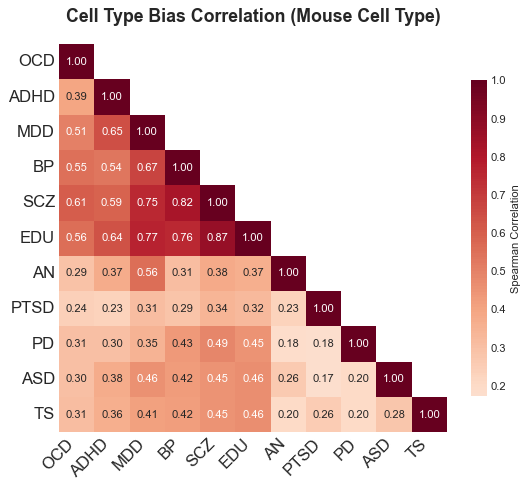

In [10]:
MouseCT_Bias_Correlation = plot_disorder_correlation_heatmap(All_Bias_DF_Spec, "Cell Type Bias Correlation (Mouse Cell Type)")
MouseCT_Bias_Correlation.to_csv("/home/jw3514/Work/UNIMED/results/pfactor/PGC_MouseCT_Correlation.csv")

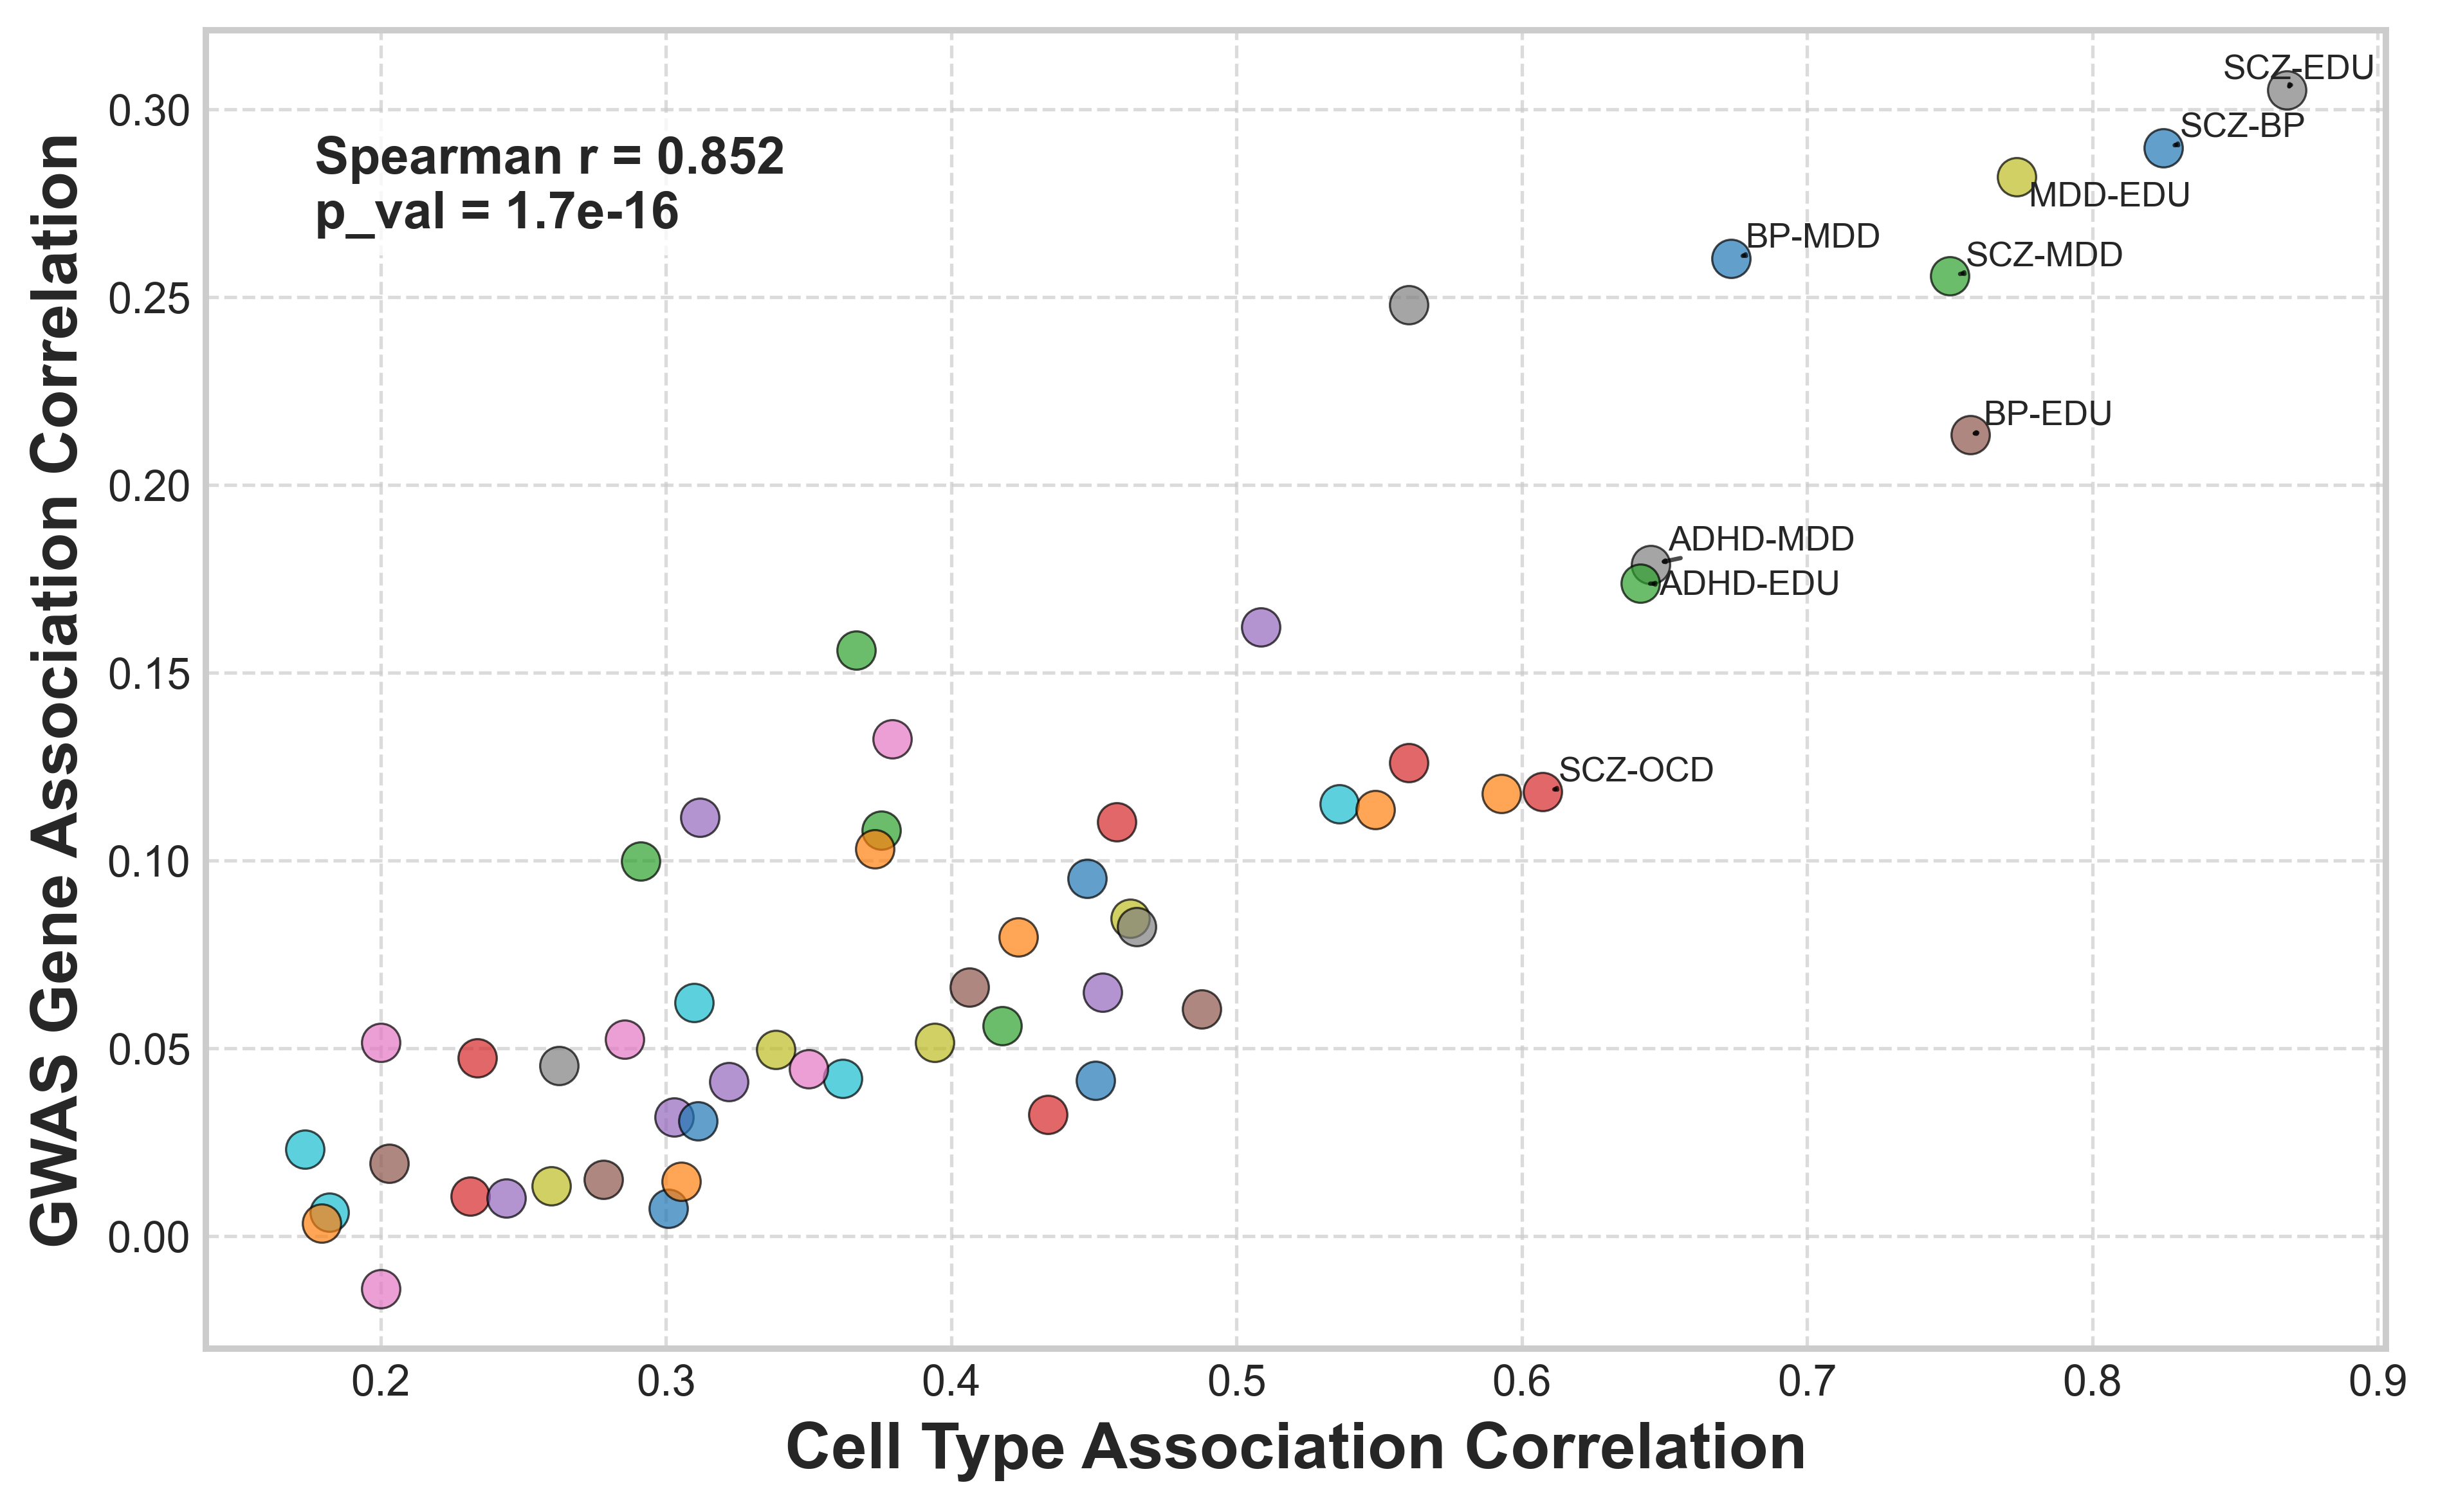

In [11]:
# Filter out meta-analysis disorders
disorders = PGC_Trait_Names

# Set figure style and size 
plt.style.use('seaborn-v0_8-whitegrid')  # Use 'seaborn' instead of deprecated 'seaborn-whitegrid'
plt.figure(figsize=(8, 5), dpi=480)

# Calculate Spearman correlation
x_values = []
y_values = []
annotations = []
for i, disorder1 in enumerate(disorders):
    for disorder2 in disorders[i+1:]:
        corr = MouseCT_Bias_Correlation.loc[disorder1, disorder2]
        x_values.append(corr)
        y_values.append(PGC_Magma_Correlation.loc[disorder1, disorder2])
        if corr > 0.6:
            annotations.append((corr, PGC_Magma_Correlation.loc[disorder1, disorder2], f"{disorder1}-{disorder2}"))

spearman_corr, p_val = stats.spearmanr(x_values, y_values)

# Get all unique disorder pairs and plot
for i, disorder1 in enumerate(disorders):
    for disorder2 in disorders[i+1:]:
        plt.scatter(MouseCT_Bias_Correlation.loc[disorder1, disorder2],
                   PGC_Magma_Correlation.loc[disorder1, disorder2],
                   alpha=0.7,
                   s=80,
                   edgecolor='black',
                   linewidth=0.5)

# Add annotations for pairs with correlation > 0.8 using adjustText
texts = []
for x, y, label in annotations:
    texts.append(plt.text(x, y, label, fontsize=8))

# Use adjustText to prevent overlapping labels
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', alpha=0.7))

# Add Spearman correlation text to plot
plt.text(0.05, 0.85, f'Spearman r = {spearman_corr:.3f}\np_val = {p_val:.1e}',
         transform=plt.gca().transAxes,
         fontsize=12,
         fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Customize plot appearance
plt.xlabel("Cell Type Association Correlation", fontsize=15, fontweight='bold')
plt.ylabel("GWAS Gene Association Correlation", fontsize=15, fontweight='bold')
#plt.title("Cell Type Bias vs Gene level association \nAcross Psychiatric Disorders",
#         fontsize=14, fontweight='bold', pad=15)

# Add grid and adjust spines
plt.grid(True, linestyle='--', alpha=0.7)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    
plt.tight_layout()
plt.show()


In [12]:
MouseCT_Bias_spec_scaled, mouseCT_bias_spec_pca, mouseCT_bias_spec_pca_result, mouseCT_bias_spec_loadings = perform_pca_analysis(All_Bias_DF_Spec)
mouseCT_bias_spec_pc_scores_df = pd.DataFrame(
    mouseCT_bias_spec_pca_result,   
    index=All_Bias_DF_Spec.index,
    columns=[f'PC{i+1}' for i in range(mouseCT_bias_spec_pca_result.shape[1])]
)

Explained variance ratios:
PC1: 0.515 (51.5%)
PC2: 0.083 (8.3%)
PC3: 0.076 (7.6%)
PC4: 0.073 (7.3%)
PC5: 0.061 (6.1%)
PC6: 0.057 (5.7%)
PC7: 0.051 (5.1%)
PC8: 0.038 (3.8%)
PC9: 0.021 (2.1%)
PC10: 0.015 (1.5%)
PC11: 0.010 (1.0%)

Cumulative variance explained: 100.0%

PC1 loadings:
SCZ     0.386343
EDU     0.382187
MDD     0.369485
BP      0.360965
ADHD    0.315868
OCD     0.276823
TS      0.246525
ASD     0.244507
AN      0.229526
PD      0.217728
PTSD    0.202010
Name: PC1, dtype: float64


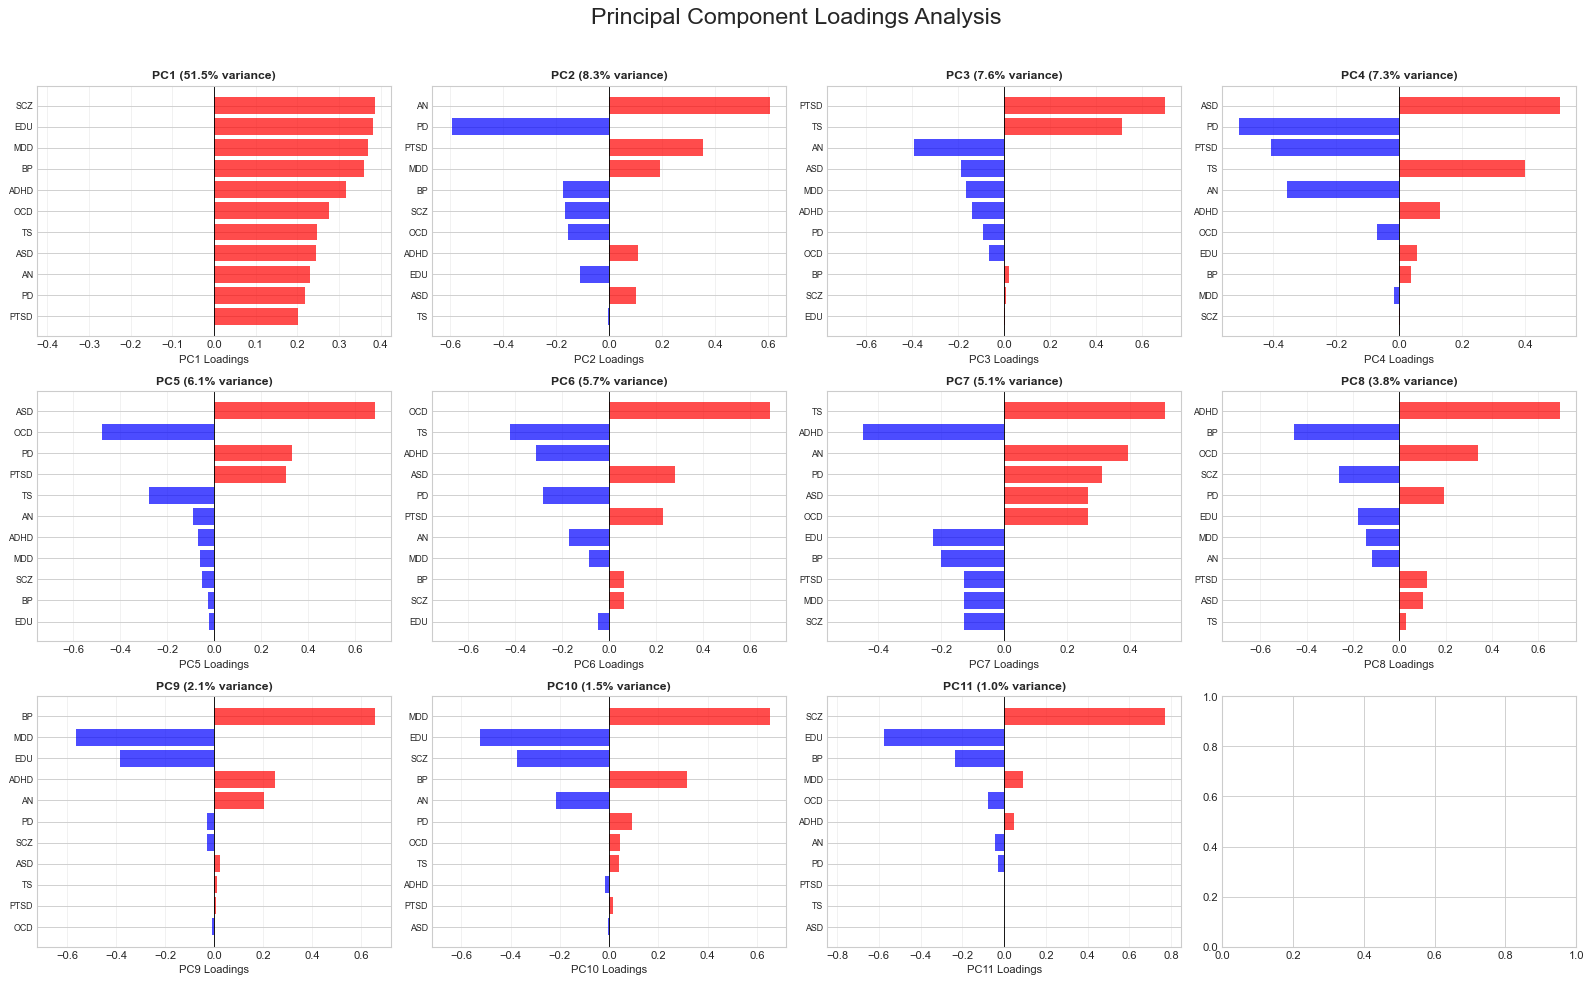

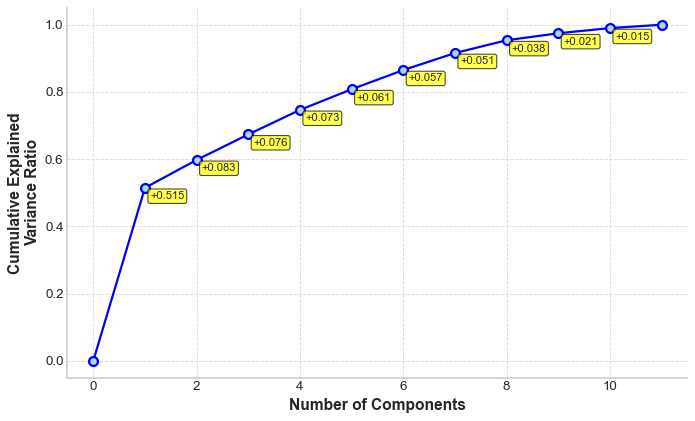

In [13]:
plot_pc_loadings(mouseCT_bias_spec_pca, All_Bias_DF_Spec)
plot_scree_and_get_loadings(mouseCT_bias_spec_pca)

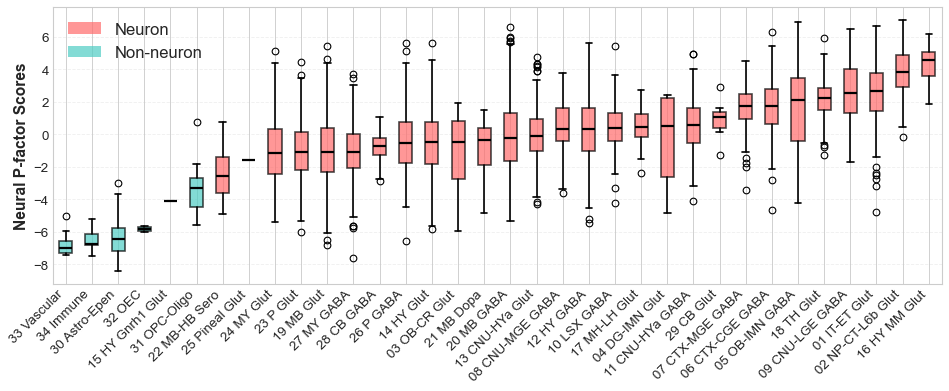

In [14]:
ClusterAnn = pd.read_csv("../dat/MouseCT_Cluster_Anno.csv", index_col="cluster_id_label")
ALL_Mouse_Class = sorted(ClusterAnn["class_id_label"].unique())
plot_pc1_boxplot_mouseCT(mouseCT_bias_spec_pc_scores_df, ClusterAnn, ALL_Mouse_Class, "PC1", ylabel="Neural P-factor Scores")

In [15]:
Jon_PSD_list = "88 102 107 114 118 119 120 150 375 476 491 538 575 577 613 659 664 747 775 815 832 1000 1020 1128 1136 1499 1500 1501 1612 1627 1630 1739 1740 1741 1742 1785 1821 1838 1855 1948 1949 2039 2043 2059 2066 2171 2185 2332 2534 2596 2785 2852 2890 2891 2892 2893 2894 2895 2897 2898 2899 2900 2901 2902 2903 2904 2905 2906 2911 2913 2915 3184 3188 3337 3631 3646 3708 3756 3836 4038 4131 4218 4355 4744 4804 4842 4897 4905 4915 4985 5028 5062 5063 5064 5071 5093 5094 5142 5170 5582 5590 5621 5662 5728 5800 5802 6009 6128 6129 6132 6136 6156 6169 6175 6188 6207 6208 6222 6223 6230 6232 6252 6334 6457 6536 6543 6546 6547 6695 6711 6790 6792 6801 6853 6854 7074 7248 7249 7428 7732 7779 8087 8224 8440 8502 8516 8661 8777 8787 8825 8831 8851 8898 8927 8997 9026 9045 9101 9148 9162 9194 9201 9228 9229 9231 9419 9454 9455 9456 9463 9478 9495 9513 9743 9746 9762 9829 9863 9867 9890 9912 9921 9922 10006 10142 10243 10280 10313 10368 10369 10458 10486 10505 10509 10611 10636 11122 11178 11331 11346 22829 22849 22865 22866 22871 22883 22941 22986 22997 23043 23208 23229 23237 23362 23380 23413 23426 23513 23542 23623 23705 23767 25945 25978 26012 26037 26045 26052 27020 27091 27092 27185 27445 28964 28988 29102 29904 50488 50944 51104 51201 51225 54477 54487 54583 54910 55327 55450 55607 55737 56899 56924 57120 57142 57479 57502 57537 57554 57622 57679 57689 58489 58512 59283 59284 64084 64101 64130 64506 66000 78999 79414 79870 79953 80315 80725 80758 80852 80863 81831 81832 81926 84062 84435 84687 85358 85461 94030 112476 114798 116443 116444 145581 145773 146395 152404 158866 160622 200933 201191 254263 339451 347731 373509 388135 388336 392862 400745 401190 440073 440829 642938 729956 729993 100131897"
Jon_PSD_list = [int(x) for x in Jon_PSD_list.split(" ")]
Jon_PSD_GW = dict(zip(Jon_PSD_list, np.ones(len(Jon_PSD_list))))
MouseCT_PSD_Spec = MouseCT_AvgZ_Weighted(BiasMat, Jon_PSD_GW)
MouseCT_PSD_Spec = add_class(MouseCT_PSD_Spec, ClusterAnn)
MouseCT_PSD_Spec.to_csv("/home/jw3514/Work/UNIMED/results/goterms/MouseCT_PSD_Spec.csv")

All cells correlation: 0.691
Neuronal correlation: 0.670
Non-neuronal correlation: 0.427


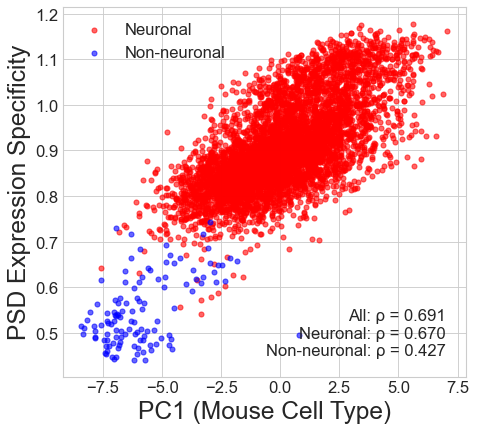

In [16]:
plot_correlation_scatter_mouseCT(mouseCT_bias_spec_pc_scores_df, MouseCT_PSD_Spec, name1="PC1 (Mouse Cell Type)", name2="PSD Expression Specificity", effect_col1="PC1", effect_col2="EFFECT")

#### Remove PC1 

In [17]:
pc1_effect = mouseCT_bias_spec_pca_result[:, 0].reshape(-1, 1) @ mouseCT_bias_spec_pca.components_[0].reshape(1, -1)
residuals = MouseCT_Bias_spec_scaled - pc1_effect
residueDF = pd.DataFrame(residuals, 
             columns=All_Bias_DF_Spec.columns,
             index=All_Bias_DF_Spec.index)

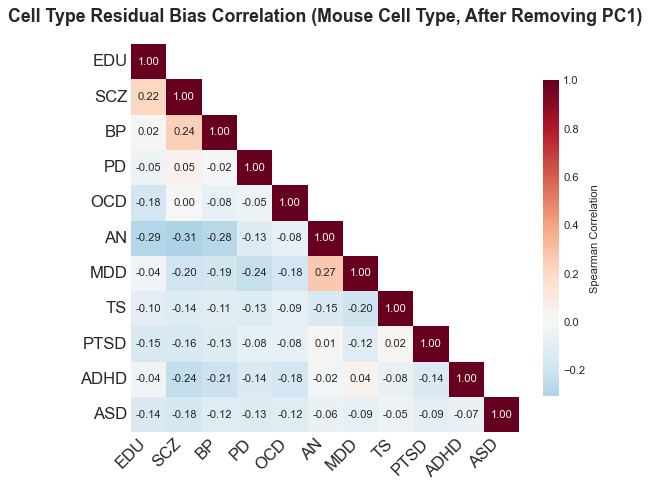

In [18]:
MouseCT_ResidueBias_Correlation = plot_disorder_correlation_heatmap(residueDF, "Cell Type Residual Bias Correlation (Mouse Cell Type, After Removing PC1)")

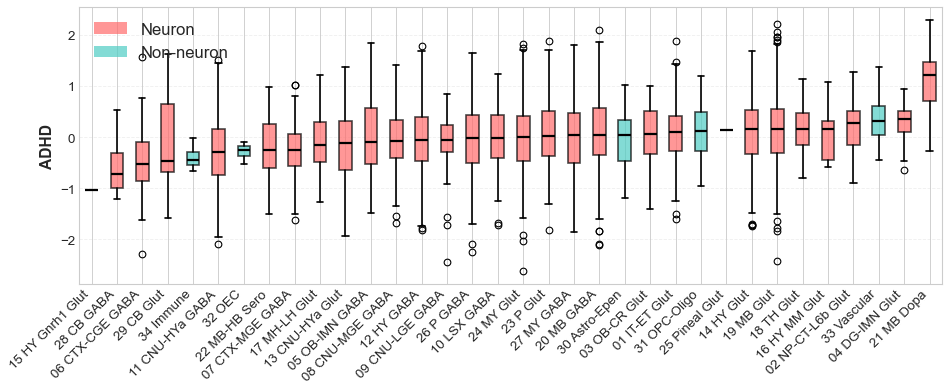

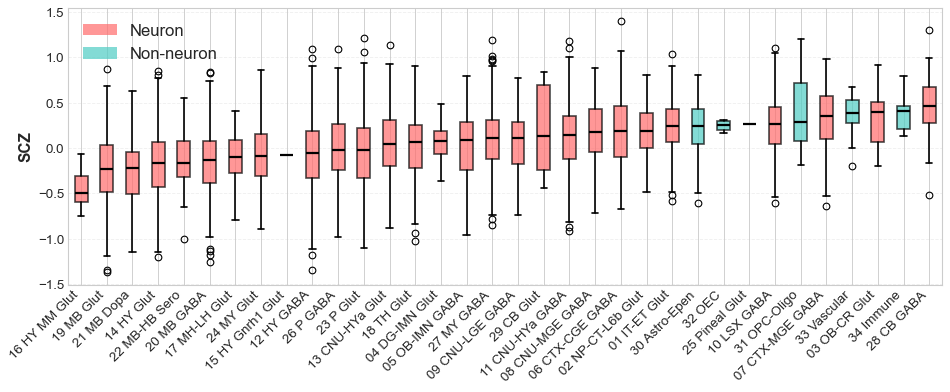

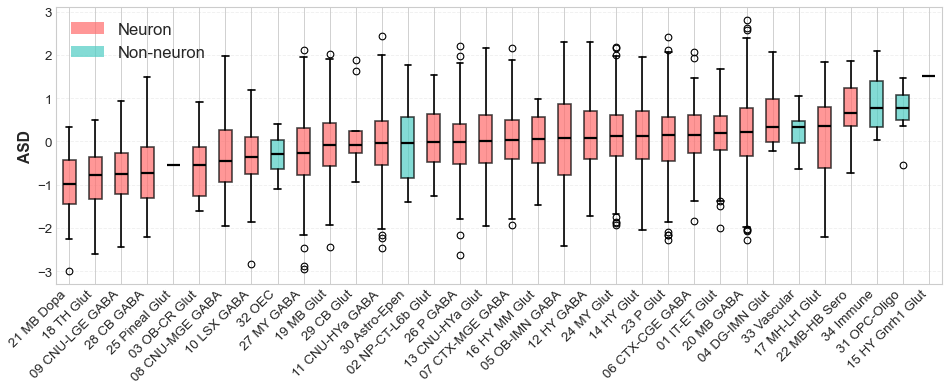

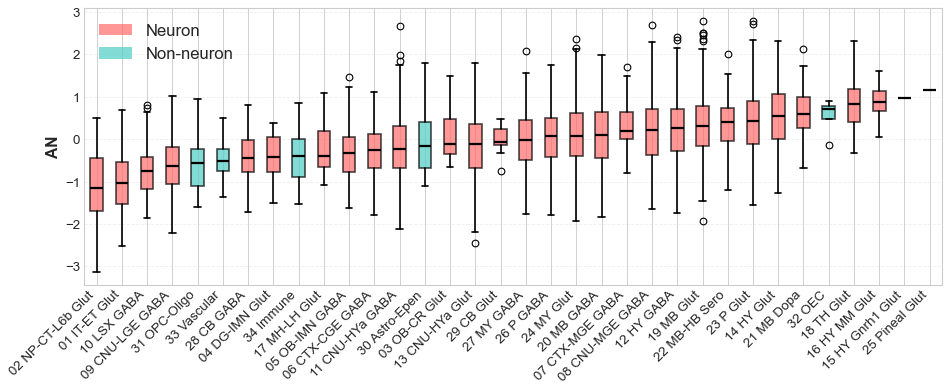

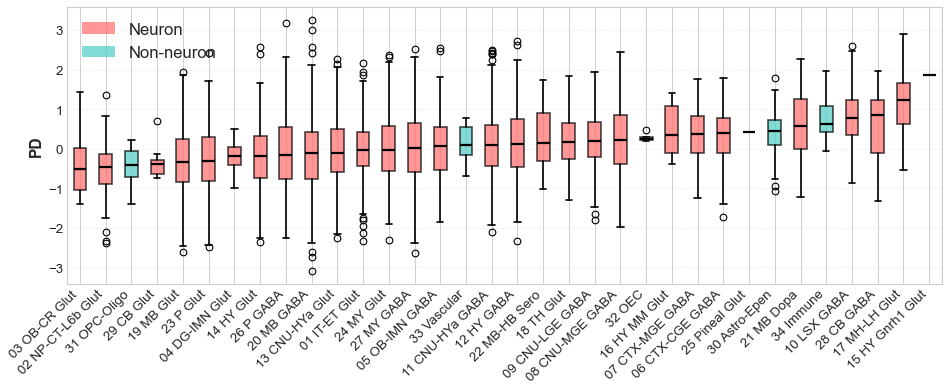

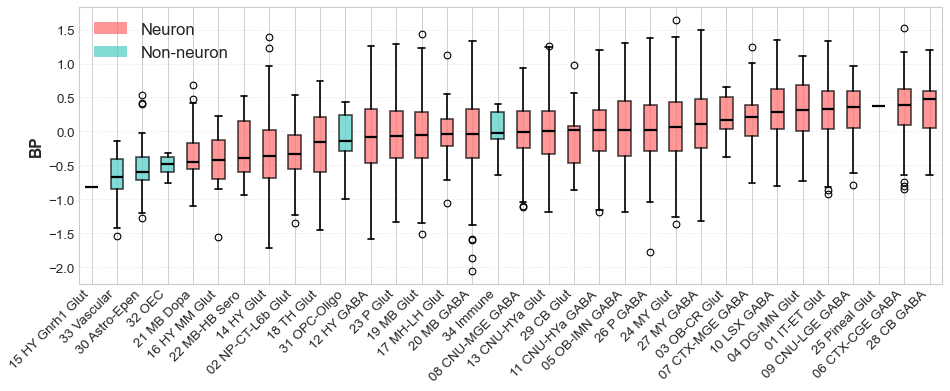

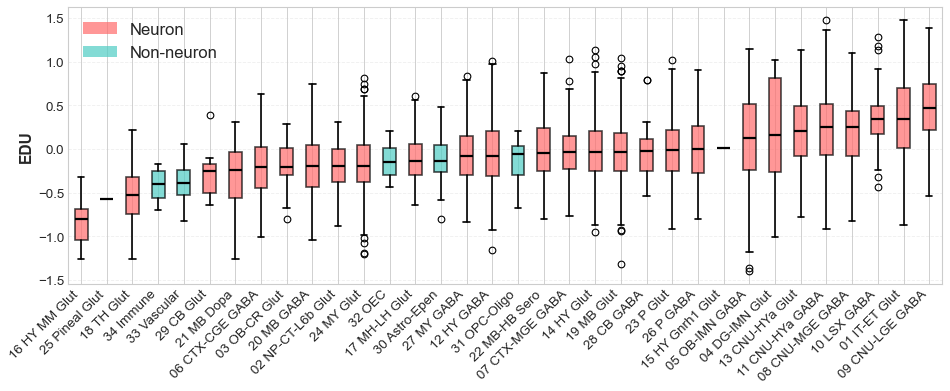

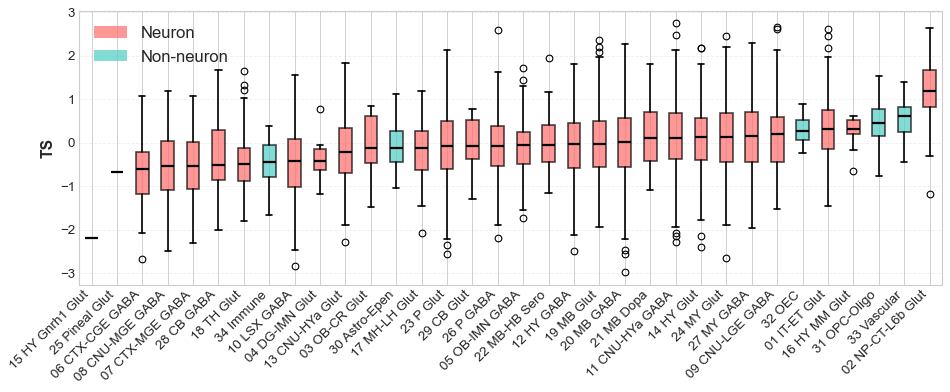

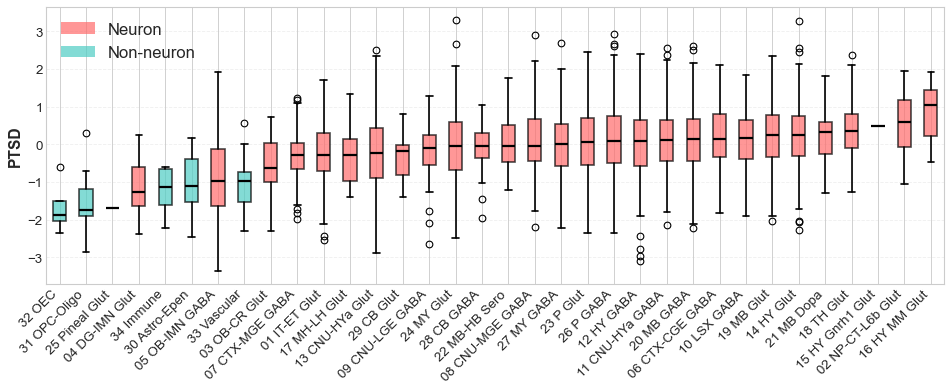

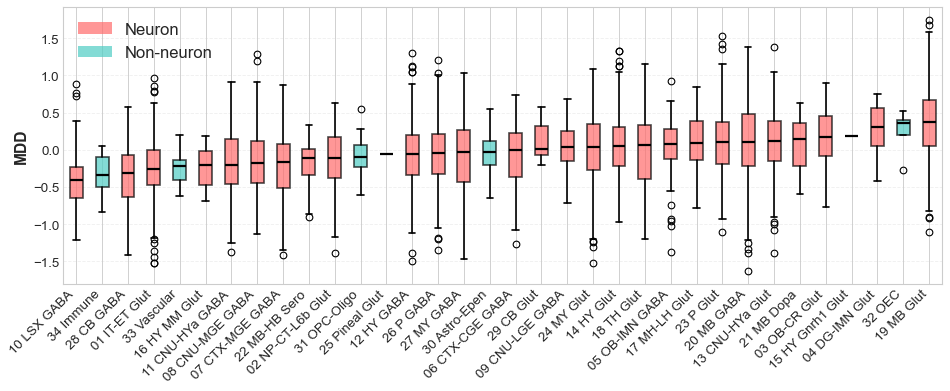

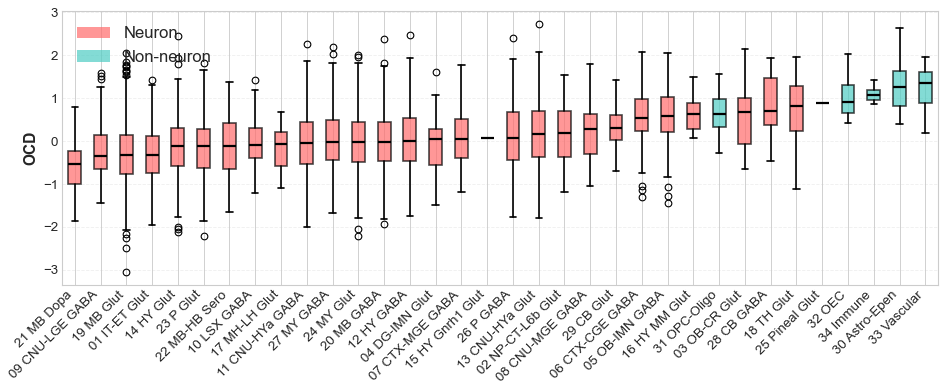

In [19]:
for Disorder in residueDF.columns.values:
   #plot_pc1_boxplot(residueDF, Anno, ALL_CTs, Disorder, Disorder)
   plot_pc1_boxplot_mouseCT(residueDF, ClusterAnn, ALL_Mouse_Class, Disorder, Disorder)

In [20]:
LOEUF = pd.read_csv("/home/jw3514/Work/UNIMED/dat/LOEUF_Rankings.csv", index_col="EntrezID")
# take top 10 decile 
topN = LOEUF.shape[0]//10
LOEUF_top10 = LOEUF.sort_values("LOEUF", ascending=True).head(topN)
print(LOEUF_top10.shape)
LOEUF_top10_GW = dict(zip(LOEUF_top10.index, np.ones(len(LOEUF_top10))))
MouseCT_LOEUF_Spec = MouseCT_AvgZ_Weighted(BiasMat, LOEUF_top10_GW)
MouseCT_LOEUF_Spec = add_class(MouseCT_LOEUF_Spec, ClusterAnn)
MouseCT_LOEUF_Spec.to_csv("/home/jw3514/Work/UNIMED/results/goterms/MouseCT_LOEUF_Spec.csv")

(1800, 4)


In [21]:
MouseCT_LOEUF_Spec.head(2)

EFFECT  Rank   class_id_label  \
ct_idx                                                              
0796 Sst Gaba_8                   1.046569     1  07 CTX-MGE GABA   
1350 CEA-AAA-BST Six3 Sp9 Gaba_1  1.044861     2  11 CNU-HYa GABA   

                                                 CCF_broad.freq  \
ct_idx                                                            
0796 Sst Gaba_8                                  Isocortex:0.97   
1350 CEA-AAA-BST Six3 Sp9 Gaba_1  sAMY:0.56,OLF:0.21,CTXsp:0.11   

                                                                   CCF_acronym.freq  \
ct_idx                                                                                
0796 Sst Gaba_8                   VISp2/3:0.23,VISp1:0.13,VISp4:0.05,NA:0.03,SSp...   
1350 CEA-AAA-BST Six3 Sp9 Gaba_1   MEA:0.29,COAa:0.17,CEAm:0.16,BMAa:0.11,CEAc:0.08   

                                  v3.size  v2.size  
ct_idx                                              
0796 Sst Gaba_8                      43.0    296.0  
1350 CEA-AAA-BST Six3 Sp9 Gaba_1    195.0     72.0